In [1]:
from numpy import *
from numpy.random import *
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import sys
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator

import pyparticleest.utils.kalman as kalman
from scipy.stats import bernoulli
import pyparticleest.interfaces as interfaces
from scipy.optimize import newton

import numpy as np
import scipy as sp
import scipy.special
import scipy.linalg

In [2]:
def resample(weights):
  n = len(weights)
  indices = []
  C = [0.] + [sum(weights[:i+1]) for i in range(n)]
  u0, j = random(), 0
  for u in [(u0+i)/n for i in range(n)]:
    while u > C[j]:
      j+=1
    indices.append(j-1)
  return indices

In [3]:
def measure(X, Y, trial):
    # log-pdf of p(y_t|x_t)
    T = X.shape[0]
    N = X.shape[1]
    coefficient = scipy.special.binom(trial,Y)
    return np.reshape(np.repeat(np.log(coefficient), N), [T,N]) + X * np.reshape(np.repeat(Y, N), [T,N]) - trial * np.log(1+np.exp(X))

In [4]:
def gaussian(X, Q):
    #log-pdf of p(x_t|x_{t-1})
    return -0.5 * (l2pi + np.log(Q) + (X ** 2) / Q)

In [5]:
def Do_Kalman_Likelihood_Bernoulli_LaplaceMAP(dN, sigma2e, tol=1e-8, trials=1.):
    """MAP solution, inverse covariance matrix, and marginal loglikelihood of state-space model
    computed using Laplace approximation around MAP state.

    :param dN: Observations (K,)
    :param sigma2e: Variance of process noise
    :param tol: Convergence criterion on the gradient of the log-likelihood
    :param trials: Number of trials for binomial observations (1 for Bernoulli)
    :return: x_map, U, marginal_loglikelihood, joint_loglikelihood
    """
    x = np.zeros(dN.shape)
    dN = dN.astype(float)
    while True:
        # Build gradient of joint
        d2x = np.convolve(x, [-1, 2, -1])[1:-1]
        d2x[-1] -= x[-1]
        G = -dN + trials * (1. / (1. + np.exp(-x))) + d2x / sigma2e
        # Build Hessian of joint
        D = trials / (np.exp(x) + 2. + np.exp(-x)) + 2. / sigma2e
        D[-1] -= 1. / sigma2e
        B = -np.ones(len(D)) / sigma2e
        B[0] = 0.
        U = sp.linalg.cholesky_banded((B, D), lower=False)
        # Check convergence
        if np.dot(G, G) < tol:
            x_map = x
            break
        # Update estimate of map
        x -= sp.linalg.cho_solve_banded([U, False], G)

    # Compute joint and marginal probabilities
    joint_loglikelihood = (np.sum(np.log(sp.special.binom(trials, dN)) + dN * x_map - trials * np.log(1 + np.exp(x_map))) -
                           .5 * ((np.sum(np.diff(x_map)**2) + x_map[0]**2) / sigma2e + len(dN) * np.log(2*np.pi*sigma2e)))
    marginal_loglikelihood = len(dN)/2. * np.log(2*np.pi) + joint_loglikelihood - np.sum(np.log(U[-1]))
    return x_map, U, marginal_loglikelihood, joint_loglikelihood

In [6]:
# Forward particles
N = 1000
# Backward trajectories
M = 30
# 
P0 = 0.01
#trial
trial = 50
#
l2pi = math.log(2 * math.pi)
#
square2pi = np.sqrt(2 * math.pi)
#
j = 15

In [7]:
#df = pd.read_csv('thaldata.csv',header=None)
#Y = df.values.reshape(3000)
#Y = Y[500:800]
#T = len(Y)
mat = np.loadtxt('train_data.txt')
Y = mat[:,1:]
T = Y.shape[1]
n = Y.shape[0]
print Y.shape

(20, 3000)


In [8]:
sigma = np.arange(0.51, 1.51, 2)
print sigma

[ 0.51]


In [9]:
loglikelihood = np.empty(len(sigma))

In [18]:
def filtering(Y, Q, mode, variance):
    samples = np.random.normal(0,1,[T+1,N])
    X = np.reshape (np.repeat(mode,N),[T+1,N]) + samples * np.reshape (np.repeat(np.sqrt(variance),N),[T+1,N])
    w = measure(X[1:], Y, trial) + gaussian(np.diff(X, axis = 0), Q) - gaussian(X[1:]-np.reshape (np.repeat(mode[1:], N) ,[T,N]), np.reshape (np.repeat(variance[1:], N) ,[T,N]))
    W = np.exp(w - np.reshape(np.repeat(np.max(w, axis =1), N), [T,N])) 
    W = W/ np.reshape(np.repeat(np.sum(W, axis =1), N), [T,N])
#     ancestor = np.empty([T,N])
#     for t in range(T):
#         ancestor[t,:]= X[t,resample(W[t,:])]
        
#     return X, w, W, ancestor
    return X, w, W

In [11]:
def smoothing(T, N, Q, M, X, W):
    w_back = np.empty(N)
    W_BACK = np.empty([T,N])
    smoother = np.empty([T,M])
    multinomialsamples = np.random.multinomial(M, W[T-1,:])
    X_nonzero = X[T, multinomialsamples>0]
    smoother[T-1,:] = np.repeat(X_nonzero, multinomialsamples[multinomialsamples>0])


    #for j in range(M):
    #    myList = np.random.multinomial(1, W[T-1,:])
    #   smoother[T-1,j] = X[T, next((i for i, x in enumerate(myList) if x), None)]
    for tt in range(T-1):
        t = T-2 - tt
        for j in range(M):
            w_back = W[t,:] * np.exp(gaussian(smoother[t+1,j]-X[t+1,:], Q))
            #w_back = W[t,:] * np.exp(-(smoother[t+1,j]-X[t,:])**2/(2.0*Q))/square2pi/np.sqrt(Q)
            W_BACK[t,:] = w_back/np.sum(w_back)
            #myList = np.random.multinomial(1, W_BACK[t,:])
            #smoother[t,j] = X[t+1, next((i for i, x in enumerate(myList) if x), None)]
            multinomialsamples = np.random.multinomial(1, W_BACK[t,:])
            smoother[t,j] = X[t+1, multinomialsamples>0]


    return smoother

In [19]:
%%time
for i in range(len(sigma)):
    Q = sigma[i]
    [x_map, U, marginal_loglikelihood, joint_loglikelihood] = Do_Kalman_Likelihood_Bernoulli_LaplaceMAP(Y[j,:], Q, 1e-8, trial) 
    mode = np.empty(T+1)
    variance = np.empty(T+1)
    mode = np.concatenate(([0],x_map))
    variance = np.concatenate(([P0],U[1]))
        
    [X, w, W] = filtering(Y[j,:], Q, mode, variance)
    maxlogweight = np.max(w, axis=1)
    weight = np.exp(w - np.reshape(np.repeat(maxlogweight, N),(T, N)))
    loglikelihood[i] = np.sum(np.log(np.sum(weight, axis = 1)/N))+np.sum(maxlogweight)

CPU times: user 905 ms, sys: 296 ms, total: 1.2 s
Wall time: 1.4 s


In [13]:
%%time
est_smooth = smoothing(T, N, Q, M, X, W)

CPU times: user 12.4 s, sys: 108 ms, total: 12.5 s
Wall time: 12.8 s


In [14]:
est_smooth

array([[-2.59034478, -2.54929576, -2.67274841, ..., -3.25902875,
        -2.21957024, -2.00873947],
       [-3.16188593, -3.07025288, -2.85621678, ..., -4.22069415,
        -2.45822667, -2.90739903],
       [-3.04795869, -2.0371577 , -2.9712746 , ..., -3.97159849,
        -3.80436888, -2.87159523],
       ..., 
       [-3.38586584, -5.38313738, -6.0418136 , ..., -3.81719525,
        -4.69756859, -5.30983243],
       [-4.30704742, -4.41582727, -5.76146037, ..., -4.39499889,
        -3.99767147, -4.85601737],
       [-5.57339298, -5.04640756, -6.24227779, ..., -5.56609731,
        -2.98151694, -5.79323778]])

In [25]:
pickle.dump(X, open('/Users/zyzrdfz/Desktop/gwungwun/cythontest_X.p','wb'))
pickle.dump(W, open('/Users/zyzrdfz/Desktop/gwungwun/cythontest_W.p','wb'))

In [ ]:
X[100,:]

In [17]:
np.concatenate(([P0],U[1])).shape

(3001,)

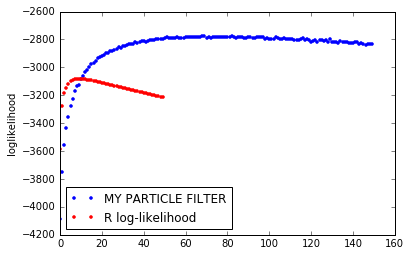

In [38]:
ll_from_R = np.loadtxt('ll_from_R.txt')
plt.plot(loglikelihood, '.',linewidth=2.0, label='MY PARTICLE FILTER')
plt.plot(ll_from_R, 'r.',linewidth=2.0, label='R log-likelihood')
plt.ylabel('loglikelihood')
plt.legend(loc='best')

In [13]:
variance

array([ 0.01      ,  2.84280297,  2.44767593, ...,  1.76906303,
        1.82095347,  1.21730545])

(array([ 116.,   31.,   25.,   21.,   12.,   12.,   12.,   11.,   12.,
          12.,   11.,   12.,   11.,   14.,   11.,   13.,   18.,   18.,
          10.,    8.,   10.,   14.,    6.,    7.,    8.,   11.,    7.,
           7.,    7.,   12.,   11.,    9.,    6.,   15.,   12.,   17.,
          12.,    7.,   12.,    7.,    8.,   10.,   12.,    7.,   12.,
          10.,    7.,   10.,   12.,   11.,    9.,    7.,    8.,    5.,
          11.,    7.,    8.,    6.,    6.,    4.,   10.,    5.,    5.,
           7.,    7.,    6.,    6.,    3.,   11.,    4.,    6.,   10.,
           6.,    7.,    7.,    6.,    1.,   10.,    6.,    8.,    8.,
           6.,    4.,    2.,    6.,    6.,    2.,    9.,    8.,    6.,
           5.,    8.,    7.,    7.,    6.,    5.,    3.,    6.,    4.,    4.]),
 array([  7.08011974e-17,   2.76614611e-05,   5.53229222e-05,
          8.29843832e-05,   1.10645844e-04,   1.38307305e-04,
          1.65968766e-04,   1.93630228e-04,   2.21291689e-04,
          2.48953150e-04

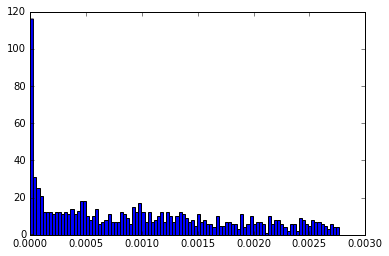

In [48]:
plt.hist(W[1000,:], 100)

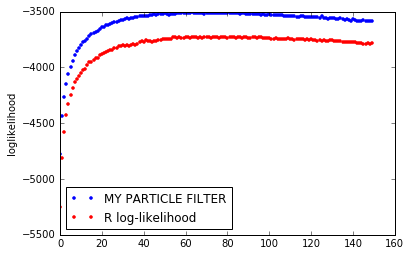

In [47]:
Y_15= pd.read_csv('row_15_ll.csv',header=0)
y15 = Y_15.values.reshape(1500,2)
y_15 = np.empty(150)
for i in range(150):
    y_15[i]= np.sum(y15[10*i:10*(i+1),1])/10.0

plt.plot(loglikelihood, '.',linewidth=2.0, label='MY PARTICLE FILTER')
plt.plot(y_15, 'r.',linewidth=2.0, label='R log-likelihood')
plt.ylabel('loglikelihood')
plt.legend(loc='best')